<a href="https://colab.research.google.com/github/nsrzmn/FYP-Tello-Drone-control-using-hand-gestures/blob/main/mediapipe_hand_gesture_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42


In [23]:
dataset = '/content/keypoint.csv'
model_save_path = '/content/keypoint_classifier.hdf5'
tflite_save_path = '/content/keypoint_classifier.tflite'

In [4]:
x_dataset = np.loadtxt(dataset, dtype='float32', delimiter=',', usecols=(list(range(1, (21 * 2)+1))))

In [6]:
y_dataset = np.loadtxt(dataset, dtype='int32', delimiter=',', usecols=(0))

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, train_size= 0.75, random_state= RANDOM_SEED)

In [8]:
print(x_train.shape)

(4642, 42)


In [9]:
print(y_train.shape)

(4642,)


(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([1595, 1663, 1510,  672,  164,  257,  139,  190]))


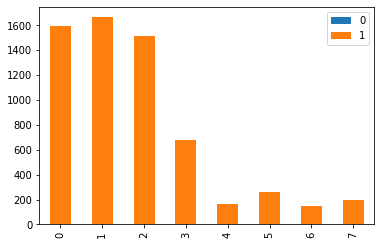

In [13]:
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)



**Model building**



In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1

In [24]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [25]:
model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
73/73 [==============================] - 0s 4ms/step - loss: 4.4671e-05 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 0.9981

Epoch 00001: val_loss improved from inf to 0.00695, saving model to /content/keypoint_classifier.hdf5
Epoch 2/1000
73/73 [==============================] - 0s 4ms/step - loss: 4.2066e-05 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9981

Epoch 00002: val_loss improved from 0.00695 to 0.00692, saving model to /content/keypoint_classifier.hdf5
Epoch 3/1000
73/73 [==============================] - 0s 4ms/step - loss: 4.0241e-05 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9981

Epoch 00003: val_loss did not improve from 0.00692
Epoch 4/1000
73/73 [==============================] - 0s 4ms/step - loss: 3.7873e-05 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 0.9981

Epoch 00004: val_loss improved from 0.00692 to 0.00685, saving model to /content/keypoint_classifier.hdf5
Epoch 5/1000
73/73 [===========================

In [26]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [28]:
val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=64)

25/25 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9987


In [36]:
predict_result = model.predict(np.array([x_test[5]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.5015858e-21 1.0000000e+00 5.8336308e-11 6.6654431e-19 6.9128545e-33
 0.0000000e+00 3.8153774e-29 4.3435363e-23]
1



**Confusion matrix**

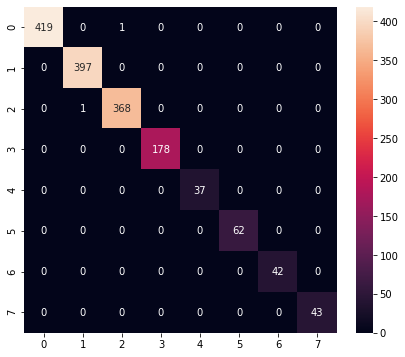

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       420
           1       1.00      1.00      1.00       397
           2       1.00      1.00      1.00       369
           3       1.00      1.00      1.00       178
           4       1.00      1.00      1.00        37
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        42
           7       1.00      1.00      1.00        43

    accuracy                           1.00      1548
   macro avg       1.00      1.00      1.00      1548
weighted avg       1.00      1.00      1.00      1548



In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [34]:

!zip -r model.zip keypoint_classifier



	zip warning: name not matched: keypoint_classifier

zip error: Nothing to do! (try: zip -r model.zip . -i keypoint_classifier)


In [38]:
prediction = model.predict(np.array([x_test[0]]))
print(np.argmax(prediction))

0
